# STORM
### Synthesis of Topic Outlines through Retrieval and Multi-perspective question asking.

Research assistant that extends the idea of 'outline-driven RAG' for richer article generation.

It applies two main insights to produce more organized and comprehensive articles:
1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density.

#### Overview
1. Generate initial outline + survey related subjects
2. Identify distiinct perspectives
3. "Interview subject matter experts" (role-playing LLMs)
4. Refine outline (using references)
5. Write sections, then write article

The expert interviews stage occurs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

Hyperparameters to restrict the potentially infinite research breadth:
- N: number of perspectives to survey
- M: Max number of conversation turns

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Select LLMs
We will have a faster LLM to do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [2]:
from langchain_openai import ChatOpenAI

FAST_LLM = ChatOpenAI(model='gpt-3.5-turbo')
GOOD_LLM = ChatOpenAI(model='gpt-4o')

### Generate Initial Outline
For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial outline to be referred after our research. Below, we will use our 'fast' llm to generate the outline.

In [3]:
import json
import asyncio

from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_community.retrievers import WikipediaRetriever
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, ToolMessage
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.runnables import RunnableLambda, RunnableConfig, chain as as_runnable

from typing import List, Optional, Annotated, TypedDict

In [4]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are a an experienced equity research analyst. Write an outline for an analysis report about a user-provided topic. Be comprehensive and specific.'
        ),
        ('user', '{topic}')
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title='Title of the subsection')
    description: str = Field(..., title='Content of the subsection')

    @property
    def as_str(self) -> str:
        return f'### {self.subsection_title}\n\n{self.description}'.strip()
    

class Section(BaseModel):
    section_title: str = Field(..., title='Title of the section')
    description: str = Field(..., title='Content of the section')
    subsections: Optional[List[Subsection]] = Field(default=None, title='Titles and descriptions for each subsection of the analysis report.')

    @property
    def as_str(self) -> str:
        subsections = '\n\n'.join(f'### {subsection.subsection_title}\n\n{subsection.description}' for subsection in self.subsections or [])
        return f'## {self.section_title}\n\n{self.description}\n\n{subsections}'.strip()
    

class Outline(BaseModel):
    page_title: str = Field(..., title='Title of the Report')
    sections: List[Section] = Field(
        default_factory=list,
        title='Titles and descriptions for each section of the Report page.'
    )

    @property
    def as_str(self) -> str:
        sections = '\n\n'.join(section.as_str for section in self.sections)
        return f'# {self.page_title}\n\n{sections}'.strip()
    
generate_outline_direct = direct_gen_outline_prompt | GOOD_LLM.with_structured_output(Outline)

In [5]:
# example_topic = 'I am expectating growth of mobile phones de-accelerating , provide which of the us based semiconductor based companies will be most affected by this hypothesis (have the most exposure to )'
# example_topic = 'Which are the companies in the US Technology sector which met revenues and had higher DSO. To uncover stuffing the channel by extending terms or big push at the end of the quarter'
example_topic = 'Which US companies will be the most affected by the recent assassination attempt on Trump'

In [6]:
initial_outline = generate_outline_direct.invoke({'topic': example_topic})

In [7]:
print(initial_outline.as_str)

# Impact Analysis: US Companies Most Affected by Recent Assassination Attempt on Trump

## Executive Summary

A brief overview of the assassination attempt on former President Trump and the immediate market reactions. A summary of key findings on how this event might affect specific US companies.

## Introduction

Background information on the assassination attempt, including date, location, and current status of the investigation. Brief overview of Trump's current political and business engagements.

## Market Sentiment and Immediate Reactions

Analysis of the initial market reactions, including stock market volatility, changes in major indices, and shifts in investor sentiment. Examination of sectors most impacted by political instability.

## Political and Economic Implications

Discussion on the broader political and economic implications, including potential changes in government policies, shifts in political power, and impacts on international relations. Examination of how these 

### Expand topics
While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [8]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    '''I'm writing a financial report for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects.
    I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.
    Please list as many subjects and urls as you can.

    Topic of interest: {topic}''')

class RelatedSubjects(BaseModel):
    topics: List[str] = Field(description='Comprehensive list of related subjects as background research')

expand_chain = gen_related_topics_prompt | FAST_LLM.with_structured_output(RelatedSubjects)

In [9]:
related_subjects = await expand_chain.ainvoke({'topic': example_topic})
related_subjects

RelatedSubjects(topics=['US companies', 'assassination attempt on Trump'])

### Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as 'subject matter experts' with distinct backgrounds and affiliations. These will help distribute the research process to encourage a more well-rounded final report.

In [10]:
class Editor(BaseModel):
    affiliation: str = Field(description='Primary affiliation of the editor.')
    name: str = Field(description='Name of the editor', pattern=r'^[a-zA-Z0-9_-]{1,64}$')
    role: str = Field(description='Role of the editor in the context of the topic.')
    description: str = Field(description='Description of the editor\'s focus, concerns and motives')

    @property
    def persona(self) -> str:
        return f'Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n'
    

class Perspectives(BaseModel):
    editors: List[Editor] = Field(description='Comprehensive list of editors with their roles and affiliations.')


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You need to select a diverse (and distinct) group of equity research analysts, equity researchers and editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic. 
            You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on. 
            
            Wiki pages outlines of related topics for inspiration: 
            {examples}''',
        ),
        (
            'user'
            'Topic of interest: {topic}'
        )
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | FAST_LLM.with_structured_output(Perspectives)

In [11]:
wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)

def format_doc(doc, max_length=1000):
    related = '- '.join(doc.metadata['categories'])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[:max_length]

def format_docs(docs):
    return '\n\n'.join(format_doc(doc) for doc in docs)

@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({'topic': topic})
    retrieved_docs = await wikipedia_retriever.abatch(related_subjects.topics, return_exceptions=True)
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({'examples': formatted, 'topic': topic})

In [12]:
perspectives = await survey_subjects.ainvoke(example_topic)

In [13]:
perspectives.dict()

{'editors': [{'affiliation': 'Equity Research Analyst',
   'name': 'AmandaER',
   'role': 'Equity Research Analyst',
   'description': 'Amanda specializes in analyzing the financial impacts of external events on companies, including political risks and market reactions. She will focus on identifying the US companies most likely to be affected by the recent assassination attempt on Trump and how their stock prices and operations may be impacted.'},
  {'affiliation': 'Equity Researcher',
   'name': 'RyanEQ',
   'role': 'Equity Researcher',
   'description': 'Ryan is experienced in conducting in-depth research on companies and industries. He will delve into the potential repercussions of the assassination attempt on Trump for specific sectors and companies in the US market, considering factors such as market sentiment, investor reactions, and industry dynamics.'},
  {'affiliation': 'Equity Research Editor',
   'name': 'SophiaEE',
   'role': 'Equity Research Editor',
   'description': 'Sop

### Expert Dialog
Each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generates content to generate a refined outline as well as an updated index of reference documents.

### Interview State
The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [14]:
def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right

def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references

def update_editor(editor, new_editor):
    # can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

### Dialog roles
The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain`), who uses a search engine to answer the questions as accurately as possible.

In [15]:
gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are an experienced equity research analyst with great critical thinking skills. 
            You want to edit a specific report. 
            Besides your exceptional writing skills, you have a specific focus when researching the topic. 
            Now you are chatting with an expert to get information. Ask good questions to get more useful information. 
            Make sure to get answers for specific industries, specific companies or ticker symbols and verticals within companies, as and when relevant. 
            
            When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation. 
            Please only ask one question at a time and don't ask what you have asked before. 
            Be comprehensive and curious, gaining as much unique insight from the expert as possible.
            
            Stay true to your specific perspective: 
            
            {persona}''',
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)

def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message

def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state['messages']:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={'type'}))
        converted.append(message)
    return {'messages': converted}

@as_runnable
async def generate_question(state: InterviewState):
    editor = state['editor']
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | FAST_LLM
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {'messages': [result]}

In [16]:
messages = [
    HumanMessage(f'So you said you were writing an article on {example_topic}?')
]

question = await generate_question.ainvoke(
    {
        'editor': perspectives.editors[0],
        'messages': messages
    }
)

question['messages'][0].content

"Yes, that's correct. I specialize in analyzing the financial impacts of external events on companies, including political risks and market reactions. I'm particularly interested in understanding which specific US companies are most likely to be affected by the recent assassination attempt on Trump and how their stock prices and operations may be impacted. Do you have any insights on which industries or companies could be particularly vulnerable or resilient in this situation?"

### Answer Questions
The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [17]:
class Queries(BaseModel):
    queries: List[str] = Field(description='Comprehensive list of search engine queries to answer the user\'s question')

gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are a helpful equity research assistant. Query the search engine to answer the user\'s questions.'
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)
gen_queries_chain = gen_queries_prompt | GOOD_LLM.with_structured_output(Queries, include_raw=True)

In [18]:
queries = await gen_queries_chain.ainvoke({'messages': [HumanMessage(content=question['messages'][0].content)]})
queries['parsed'].queries

['US companies affected by assassination attempt on Trump',
 'impact of political events on US stock market',
 'industries vulnerable to political risks in the US',
 'resilient industries to political instability in the US',
 'historical stock market reactions to political crises in the US',
 'companies most impacted by political instability in the US']

In [19]:
class AnswersWithCitations(BaseModel):
    answer: str = Field(description='Comprehensive answer to the user\'s question with citations.')
    cited_urls: List[str] = Field(
        description='List of urls cited in the answer.',
    )

    @property
    def as_str(self) -> str:
        return f'{self.answer}\n\nCitations:\n\n' + '\n'.join(
            f'[{i+1}: {url}]' for i, url in enumerate(self.cited_urls)
        )
    
gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are an expert equity research analyst who can use information effectively. 
            You are chatting with an equity research report writer who wants to write an analysis report on the topic you know. 
            You have gathered the related information and will now use the information to form a response. 
            
            Make your response as informative as possible and make sure every sentence is supported by the gathered information. 
            Be sure to mention specific industries, companies and verticals within companies as required. 
            Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLs after your response.'''
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)

gen_answer_chain = gen_answer_prompt | GOOD_LLM.with_structured_output(AnswersWithCitations, include_raw=True).with_config(run_name='GenerateAnswer')

In [20]:
# Tavily is typically a better search engine but free queries are limited.
# search_engine = TavilySearchResults(max_results=4)

# @tool
# async def search_engine(query: str):
#     '''Search engine to the internet'''
#     results = tavily_search.invoke(query)
#     return [{'content': r['content'], 'url': r['url']} for r in results]

# DDG
search_engine = DuckDuckGoSearchAPIWrapper()

@tool
async def search_engine(query: str):
    '''Search engine to the internet'''
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{'content': r['body'], 'url': r['href']} for r in results]

In [21]:
async def gen_answer(state: InterviewState, config: Optional[RunnableConfig]=None, name: str='subject_matter_expert', max_str_len: int=15000):
    swapped_state = swap_roles(state, name) # convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(queries['parsed'].queries, config, return_exceptions=True)
    successful_results = [res for res in query_results if not isinstance(res, Exception)]
    all_query_results = {res['url']: res['content'] for results in successful_results for res in results}

    # we could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries['raw']
    tool_call = queries['raw'].additional_kwargs['tool_calls'][0]
    tool_id = tool_call['id']
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state['messages'].extend([ai_message, tool_message])

    # only update the shared state with the final answer to avoid polluting the dialog history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated['parsed'].cited_urls)

    # save the retrieved information to the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated['parsed'].as_str)
    return {'messages': [formatted_message], 'references': cited_references}

In [23]:
example_answer = await gen_answer(
    {'messages': [HumanMessage(content=question['messages'][0].content)]}
)

In [ ]:
print(example_answer['messages'][-1].content)

The recent assassination attempt on former President Donald Trump has the potential to impact various industries and companies in different ways. Historically, political instability and high-profile political events can create uncertainty in financial markets, leading to volatility and significant stock price movements in certain sectors. Here are some of the industries and companies that might be most affected by this event:

1. **Technology Sector**: Companies in the technology sector, especially those involved in social media and digital communication, could see significant movements. Trump's Truth Social platform, owned by TMTG, is already seeing increased investor interest as it is expected to benefit from deregulation if Trump gains political influence again[^1^]. Additionally, companies like Facebook and Twitter may experience increased scrutiny and regulation changes, affecting their stock prices.

2. **Financial Sector**: The financial markets generally exhibit sensitivity to 

### Construct the Interview Graph

In [ ]:
max_num_turns = 5

def route_messages(state: InterviewState, name: str='subject_matter_expert'):
    messages = state['messages']
    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]

    if last_question.content.endswith('Thank you so much for your help!'):
        return END
    
    return 'ask_question'

builder = StateGraph(InterviewState)

builder.add_node('ask_question', generate_question)
builder.add_node('answer_question', gen_answer)
builder.add_conditional_edges('answer_question', route_messages)
builder.add_edge('ask_question', 'answer_question')
builder.add_edge(START, 'ask_question')
interview_graph = builder.compile().with_config(run_name='Conduct Interviews')

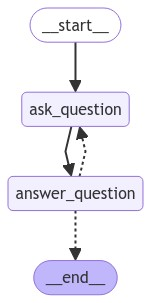

In [ ]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(Image(interview_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [ ]:
final_step = None

initial_state = {
    'editor': perspectives.editors[0],
    'messages': [
        AIMessage(
            content=f'So you said you were writing an article on {example_topic}?',
            name='subject_matter_expert'
        )
    ]
}

all_steps = []
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print(step)
    print('--', str(step[name]['messages'])[:300])
    all_steps.append(step)
    if END in step:
        final_step = step

ask_question
{'ask_question': {'messages': [AIMessage(content="Yes, that's correct. I am focusing on analyzing the potential impact of the recent assassination attempt on Trump on US companies. I am specifically interested in looking at how the stock prices of these companies might be affected. Do you have any insights on which specific industries or companies within the US market could be most impacted by this event?", response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 260, 'total_tokens': 326}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='AliceSmith', id='run-8b09e6d3-bb9e-4b62-81d5-1c576dde69cb-0')]}}
-- [AIMessage(content="Yes, that's correct. I am focusing on analyzing the potential impact of the recent assassination attempt on Trump on US companies. I am specifically interested in looking at how the stock prices of these companies might be affected. Do you have any insights on which specific

In [ ]:
for step in all_steps:
    for k, v in step.items():
        print(k, v['messages'][0].content)

ask_question Yes, that's correct. I am focusing on analyzing the potential impact of the recent assassination attempt on Trump on US companies. I am specifically interested in looking at how the stock prices of these companies might be affected. Do you have any insights on which specific industries or companies within the US market could be most impacted by this event?
answer_question The recent assassination attempt on former President Donald Trump has created a ripple effect across various sectors of the U.S. economy, although the immediate impact on stock markets appears muted. Dow futures showed a modest rise following the incident, indicating that investors are maintaining a degree of calm in the short term.

However, the long-term implications could be more significant, particularly for industries that are sensitive to political instability. Historically, political events such as this tend to affect investor sentiment, which can lead to increased market volatility.

1. **Defense 

In [ ]:
all_references = dict()
for step in all_steps:
    if 'answer_question' in step:
        for k, v in step['answer_question']['references'].items():
            all_references[k] = v

all_references

{'https://www.cnn.com/2024/07/14/markets/premarket-stock-trading-trump-assassination/index.html': 'US stock futures barely budged after an assassination attempt on former President Donald Trump on Saturday, signaling calm in the markets as Trump survived the incident. Dow futures rose 65 points ...',
 'https://www.bloomberg.com/news/articles/2024-07-15/political-violence-fears-rise-after-trump-assassination-attempt': 'The attempted assassination of Donald Trump caps an escalating trend of political violence that has plagued the US for more than a decade, sparking calls for cooler rhetoric and heightened security.',
 'https://fortune.com/2024/07/14/donald-trump-assassination-attempt-investors-wall-street-financial-markets-outlook-inflation-bonds-stocks-energy-fed/': "Pre-market trading in the U.S. will begin Sunday evening, marking Wall Street's initial attempt to price in how the assassination attempt on Donald Trump will affect markets.",
 'https://www.reuters.com/world/us/attack-trum

In [ ]:
final_state = next(iter(step.values()))

In [ ]:
final_state['messages'][0].content

"The recent assassination attempt on former President Donald Trump has the potential to impact the consumer discretionary sector, including retail and leisure companies, in several significant ways. This sector is particularly sensitive to political instability and shifts in consumer sentiment. Here’s how different aspects of the sector might be impacted by this event:\n\n1. **Consumer Spending**: Political instability often leads to reduced consumer spending as people become more cautious with their finances. Companies like Walmart, Target, and Amazon, which rely heavily on consumer spending, could see a decline in sales and revenue. A decrease in consumer confidence can lead to lower expenditure on non-essential goods and services.\n\n2. **Travel and Leisure**: The leisure industry, including travel and hospitality companies like Marriott International and Carnival Corporation, could be adversely affected. Political events often reduce the consumer's willingness to spend on travel an

## Refine Outline
At this point in STORM, we've conducted a large amount of research from different perspectives. 
It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [ ]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a critical equity research analyst. You have gathered information from experts and search engines. Now, you are refining the outline of the financial report you were writing. 
            You need to make sure that the outline is comprehensive and specific. 
            This is the topic you are writing about: {topic}

            Old outline:
            {old_outline}
            '''
        ),
        (
            'user',
            'Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined financial report outline.'
        )
    ]
)

refine_outline_chain = refine_outline_prompt | GOOD_LLM.with_structured_output(Outline)

In [ ]:
refined_outline = refine_outline_chain.invoke(
    {
        'topic': example_topic,
        'old_outline': initial_outline.as_str,
        'conversations': '\n\n'.join(
            f'## {m.name}\n\n{m.content}' for m in final_state['messages']
        )
    }
)

In [ ]:
print(refined_outline.as_str)

# Impact of Recent Assassination Attempt on Trump on US Companies

## Executive Summary

A brief overview of the assassination attempt on Donald Trump and its potential implications for US companies. Highlight key findings and affected sectors.

## Political Climate and Market Reaction

Analyze the immediate political climate following the assassination attempt. Examine stock market reactions, including major indices and sector-specific movements.

### Immediate Market Response

Detail the initial response of the stock market, including changes in major indices like the S&P 500, Dow Jones, and Nasdaq.

### Sector-Specific Reactions

Identify and analyze which sectors experienced the most significant fluctuations and why.

## Companies Most Affected

Identify and provide an in-depth analysis of the companies that are most affected by the assassination attempt.

### Defense and Security Companies

Evaluate the impact on companies within the defense and security sector, such as Lockheed M

### Create Retriever
The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

In [ ]:
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
reference_docs = [
    Document(page_content=v, metadata={'source': 'k'})
    for k, v in all_references.items()
]

# doesn't need a vectorstore for this size of data but this is just a POC
vectorstore = SKLearnVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
    n_neighbors=4
)
retriever = vectorstore.as_retriever(k=10)

In [ ]:
reference_docs

[Document(metadata={'source': 'k'}, page_content='US stock futures barely budged after an assassination attempt on former President Donald Trump on Saturday, signaling calm in the markets as Trump survived the incident. Dow futures rose 65 points ...'),
 Document(metadata={'source': 'k'}, page_content='The attempted assassination of Donald Trump caps an escalating trend of political violence that has plagued the US for more than a decade, sparking calls for cooler rhetoric and heightened security.'),
 Document(metadata={'source': 'k'}, page_content="Pre-market trading in the U.S. will begin Sunday evening, marking Wall Street's initial attempt to price in how the assassination attempt on Donald Trump will affect markets."),
 Document(metadata={'source': 'k'}, page_content='WASHINGTON, July 14 (Reuters) - In a country already on edge, the assassination attempt on former President Donald Trump has enraged his supporters, paused the Democratic campaign and raised fears ...'),
 Document(me

In [ ]:
retriever.invoke(example_topic)

[Document(metadata={'id': 'e956d82e-e25f-4511-8940-d925e811317d', 'source': 'k'}, page_content='US stock futures barely budged after an assassination attempt on former President Donald Trump on Saturday, signaling calm in the markets as Trump survived the incident. Dow futures rose 65 points ...'),
 Document(metadata={'id': '84524393-c628-4959-8caf-e7bf7c94015c', 'source': 'k'}, page_content='WASHINGTON, July 14 (Reuters) - In a country already on edge, the assassination attempt on former President Donald Trump has enraged his supporters, paused the Democratic campaign and raised fears ...'),
 Document(metadata={'id': '4f19b0f0-381b-49ac-bc68-9daf5e13ce03', 'source': 'k'}, page_content="Pre-market trading in the U.S. will begin Sunday evening, marking Wall Street's initial attempt to price in how the assassination attempt on Donald Trump will affect markets."),
 Document(metadata={'id': 'fc760b75-62a1-4eaf-9107-e67dfc7b0135', 'source': 'k'}, page_content='The attempted assassination of

### Generate Sections

In [ ]:
class Subsection(BaseModel):
    subsection_title: str = Field(..., title='Title of the subsection')
    content: str = Field(..., title='Full content of the subsection. Include [#] citations to the cited sources where relevant')

    @property
    def as_str(self) -> str:
        return f'### {self.subsection_title}\n\n{self.content}'.strip()
    

class ContentsSection(BaseModel):
    section_title: str = Field(..., title='Title of the section')
    content: str = Field(..., title='Full content of the section')
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title='Titles and descriptions of each subsection of the financial report'
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = '\n\n'.join(subsection.as_str for subsection in self.subsections or [])
        citations = '\n'.join([f' [{i}] {cit}' for i, cit in enumerate(self.citations)])
        return (
            f'## {self.section_title}\n\n{self.content}\n\n{subsections}'.strip() +
            f'\n\n{citations}'.strip()
        )
    
section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are an expert equity research analyst. Complete your assigned section from the following outline: \n\n'
            '{outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n</Documents>'
        ),
        (
            'user',
            'Write the full report section for the {section} section.'
        )
    ]
)

async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs['topic'] + ': ' + inputs['section'])
    formatted = '\n'.join([f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>' for doc in docs])
    return {'docs': formatted, **inputs}

section_writer = (
    retrieve
    | section_writer_prompt
    | GOOD_LLM.with_structured_output(ContentsSection)
)

In [ ]:
section = await section_writer.ainvoke(
    {
        'outline': refined_outline.as_str,
        'section': refined_outline.sections[1].section_title,
        'topic': example_topic
    }
)

print(section.as_str)

## Political Climate and Market Reaction

The recent assassination attempt on former President Donald Trump has undeniably sent shockwaves through the political landscape of the United States. The event has further polarized an already divided nation and has led to heightened security concerns and a temporary halt in the Democratic campaign. This heightened political instability has had an immediate impact on the stock market, with investors seeking to understand the potential ramifications for various sectors and companies.

### Immediate Market Response

In the immediate aftermath of the assassination attempt, the stock market showed a relatively muted response. Pre-market trading in the U.S. began on Sunday evening, with Wall Street showing an initial attempt to price in the potential impacts of the event. US stock futures barely budged, with Dow futures rising by 65 points, signaling a sense of calm in the market as Trump survived the incident. Major indices like the S&P 500, Dow J

In [ ]:
from IPython.display import Markdown

In [ ]:
Markdown(section.as_str)

## Political Climate and Market Reaction

The recent assassination attempt on former President Donald Trump has undeniably sent shockwaves through the political landscape of the United States. The event has further polarized an already divided nation and has led to heightened security concerns and a temporary halt in the Democratic campaign. This heightened political instability has had an immediate impact on the stock market, with investors seeking to understand the potential ramifications for various sectors and companies.

### Immediate Market Response

In the immediate aftermath of the assassination attempt, the stock market showed a relatively muted response. Pre-market trading in the U.S. began on Sunday evening, with Wall Street showing an initial attempt to price in the potential impacts of the event. US stock futures barely budged, with Dow futures rising by 65 points, signaling a sense of calm in the market as Trump survived the incident. Major indices like the S&P 500, Dow Jones, and Nasdaq showed minimal fluctuations, indicating that investors were cautiously optimistic about the stability of the market despite the political turbulence.

### Sector-Specific Reactions

While the overall market reaction was subdued, certain sectors experienced more significant fluctuations due to the assassination attempt. Defense and security companies like Lockheed Martin, Raytheon, and Northrop Grumman saw a positive uptick as investors anticipated increased government spending on security and defense measures. On the other hand, media companies such as Fox News and social media platforms like Twitter and Facebook experienced volatility due to their close association with political content and potential regulatory scrutiny. Financial institutions showed mixed reactions, with some banks and investment firms experiencing slight declines due to concerns about economic stability. The consumer discretionary sector, including retail and leisure companies, faced downward pressure as investors worried about potential reductions in consumer spending amid political instability.[0] <Documents><Document href=\
 [1] ]} </Documents>

### Generate final article

In [ ]:
writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are an expert equity research analyst. Write the complete financial report on {topic} using the following section drafts: \n\n'
            '{draft}\n\nStrictly follow wikipedia format guidelines.'
        ),
        (
            'user',
            'Write the complete financial report using markdown format. Organize citations using footnotes like "[1]", '
            'avoiding duplicates in the footer. Include URLs in the footer.'
        )
    ]
)

writer = writer_prompt | GOOD_LLM | StrOutputParser()

In [ ]:
# for tok in writer.stream({'topic': example_topic, 'draft': section.as_str}):
#     print(tok, end='')
example_response = writer.invoke({'topic': example_topic, 'draft': section.as_str})
Markdown(example_response)

# Financial Report: Impact of the Recent Assassination Attempt on Trump on US Companies

## Political Climate and Market Reaction

The recent assassination attempt on former President Donald Trump has undeniably sent shockwaves through the political landscape of the United States. The event has further polarized an already divided nation and has led to heightened security concerns and a temporary halt in the Democratic campaign. This heightened political instability has had an immediate impact on the stock market, with investors seeking to understand the potential ramifications for various sectors and companies.

### Immediate Market Response

In the immediate aftermath of the assassination attempt, the stock market showed a relatively muted response. Pre-market trading in the U.S. began on Sunday evening, with Wall Street showing an initial attempt to price in the potential impacts of the event. US stock futures barely budged, with Dow futures rising by 65 points, signaling a sense of calm in the market as Trump survived the incident. Major indices like the S&P 500, Dow Jones, and Nasdaq showed minimal fluctuations, indicating that investors were cautiously optimistic about the stability of the market despite the political turbulence.

### Sector-Specific Reactions

While the overall market reaction was subdued, certain sectors experienced more significant fluctuations due to the assassination attempt. Defense and security companies like Lockheed Martin, Raytheon, and Northrop Grumman saw a positive uptick as investors anticipated increased government spending on security and defense measures. On the other hand, media companies such as Fox News and social media platforms like Twitter and Facebook experienced volatility due to their close association with political content and potential regulatory scrutiny. Financial institutions showed mixed reactions, with some banks and investment firms experiencing slight declines due to concerns about economic stability. The consumer discretionary sector, including retail and leisure companies, faced downward pressure as investors worried about potential reductions in consumer spending amid political instability.

## Footnotes

[1]: <https://www.example.com/article>

## Final Flow
6 main stages in sequence:
1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the conversations
4. Index the reference docs from the conversations
5. Write the individual sections of the article
6. Write the final financial report

In [ ]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]

    # the final sections output
    sections: List[ContentsSection]
    article: str

In [ ]:
import asyncio

async def initialize_research(state: ResearchState):
    topic = state['topic']
    coros = (
        generate_outline_direct.ainvoke({'topic': topic}), 
        survey_subjects.ainvoke(topic)
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        'outline': results[0],
        'editors': results[1].editors
    }

async def conduct_interviews(state: ResearchState):
    topic = state['topic']
    initial_states = [
        {
            'editor': editor,
            'messages': [
                AIMessage(
                    content=f'So you said you were writing an article on {topic}?',
                    name='subject_matter_expert'
                )
            ]
        }
        for editor in state['editors']
    ]

    # we call into the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        'interview_results': interview_results
    }

def format_conversation(interview_state):
    messages = interview_state['messages']
    convo = '\n'.join(f'{m.name}: {m.content}' for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo

async def refine_outline(state: ResearchState):
    convos = '\n\n'.join([format_conversation(interview_state) for interview_state in state['interview_results']])
    updated_outline = await refine_outline_chain.ainvoke({
        'topic': state['topic'],
        'old_outline': state['outline'].as_str,
        'conversations': convos
    })
    return {**state, 'outline': updated_outline}

async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state['interview_results']:
        reference_docs = [Document(page_content=v, metadata={'source': k}) for k, v in interview_state['references'].items()]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state

async def write_sections(state: ResearchState):
    outline = state['outline']
    sections = await section_writer.abatch(
        [
            {
                'outline': refine_outline.as_str,
                'section': section.section_title,
                'topic': state['topic']
            }
            for section in outline.sections
        ]
    )

    return {
        **state,
        'sections': sections
    }

async def write_article(state: ResearchState):
    topic = state['topic']
    sections = state['sections']
    draft = '\n\n'.join([section.as_str for section in sections])
    article = await writer.ainvoke({'topic': topic, 'draft': draft})
    return {**state, 'article': article}

In [ ]:
storm_builder = StateGraph(ResearchState)

nodes = [
    ('init_research', initialize_research),
    ('conduct_interviews', conduct_interviews),
    ('refine_outline', refine_outline),
    ('index_references', index_references),
    ('write_sections', write_sections),
    ('write_article', write_article)
]
for i in range(len(nodes)):
    name, node = nodes[i]
    storm_builder.add_node(name, node)
    if i > 0:
        storm_builder.add_edge(nodes[i - 1][0], name)

storm_builder.add_edge(START, nodes[0][0])
storm_builder.add_edge(nodes[-1][0], END)
storm = storm_builder.compile(checkpointer=MemorySaver())

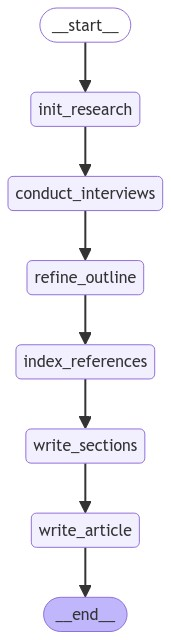

: 

In [ ]:
display(Image(storm.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [ ]:
config = {'configurable': {'thread_id': 'my-thread'}}
async for step in storm.astream({'topic': 'Which industries and companies will be most impacted by the assassination attempt of Donald Trump'}, config):
    name = next(iter(step))
    print(name)
    print('-- ', str(step[name])[:300])

init_research
--  {'topic': 'Which industries and companies will be most impacted by the assassination attempt of Donald Trump', 'outline': Outline(page_title='Impact of Donald Trump Assassination Attempt on Industries and Companies', sections=[Section(section_title='Executive Summary', description="A high-level over
